In [28]:
import pandas as pd
df = pd.read_csv('all_stocks_5yr.csv')

In [29]:
df = df[df['Name']!='GOOG']

In [30]:
df['dt'] = pd.to_datetime(df['Date'])
df['year'] = df['dt'].dt.year


In [31]:
df['month'] = df['dt'].dt.month
df['year_month'] = df['year'].astype(str) + '_' + df['month'].astype('str')
df = df.sort_values('dt')

def calculate_returns(df):
    return (df['Close'].iloc[-1] - df['Open'].iloc[0] ) / df['Open'].iloc[0]

In [32]:
ml = pd.DataFrame()
ml['returns_2014'] = df[df['year'] == 2014].groupby('Name').apply(calculate_returns)
ml['returns_2015'] = df[df['year'] == 2015].groupby('Name').apply(calculate_returns)
ml['returns_2016'] = df[df['year'] == 2016].groupby('Name').apply(calculate_returns)
df[df['year'] == 2016].groupby('Name').apply(calculate_returns)

Name
A       0.109596
AAL     0.130782
AAP     0.133132
AAPL    0.128740
ABBV    0.078539
          ...   
XYL     0.378619
YUM    -0.112030
ZBH     0.020570
ZION    0.620482
ZTS     0.140392
Length: 498, dtype: float64

In [33]:
a = df[df['year'].isin([2014,2015])].groupby(['Name','year_month']).apply(calculate_returns)
ml = a.reset_index().pivot_table(index='Name',columns='year_month',values=0)
ml['returns_2016'] = df[df['year'] == 2016].groupby('Name').apply(calculate_returns)
ml['returns_2014'] = df[df['year'] == 2014].groupby('Name').apply(calculate_returns)
ml['returns_2015'] = df[df['year'] == 2015].groupby('Name').apply(calculate_returns)
ml['target'] = ml['returns_2016'] >= 0.15
ml['target'].value_counts()

False    271
True     221
Name: target, dtype: int64

In [34]:
ml = ml.dropna()
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
clf = RandomForestClassifier(random_state = 42)
ml = ml.sample(frac=1,random_state = 41)

cols_1 = ['2014_1', '2014_10', '2014_11', '2014_12', '2014_2', '2014_3', '2014_4',
       '2014_5', '2014_7', '2014_8', '2014_9', '2015_1',
       '2015_11', '2015_12', '2015_2', '2015_3', '2015_4', '2015_5', '2015_6',
       '2015_7', '2015_8', '2015_9','returns_2014','returns_2015']
year_2015_months = ['2015_1','2015_11', '2015_12', '2015_2', '2015_3', '2015_4', '2015_5', '2015_6','2015_7', '2015_8', '2015_9']
ml['max_month_2015'] = ml.loc[:, year_2015_months].apply(lambda x: x.max(),axis=1)
ml['min_month_2015'] = ml.loc[:, year_2015_months].apply(lambda x: x.min(),axis=1)
ml['mean_month_2015'] = ml.loc[:, year_2015_months].apply(lambda x: x.mean(),axis=1)
ml['std_month_2015'] = ml.loc[:, year_2015_months].apply(lambda x: x.std(),axis=1)

year_2014_months = ['2014_1','2014_11', '2014_12', '2014_2', '2014_3', '2014_4', '2014_5', '2014_6','2014_7', '2014_8', '2014_9']
ml['max_month_2014'] = ml.loc[:, year_2015_months].apply(lambda x: x.max(),axis=1)
ml['min_month_2014'] = ml.loc[:, year_2015_months].apply(lambda x: x.min(),axis=1)
ml['mean_month_2014'] = ml.loc[:, year_2015_months].apply(lambda x: x.mean(),axis=1)
ml['std_month_2014'] = ml.loc[:, year_2015_months].apply(lambda x: x.std(),axis=1)
ml['vol_at_2014_1'] = df[df['year_month'] =='2014_1'].groupby('Name')['Volume'].mean()
ml['vol_at_2014_12'] = df[df['year_month'] =='2014_12'].groupby('Name')['Volume'].mean()
ml['vol_at_2015_1'] = df[df['year_month'] =='2015_1'].groupby('Name')['Volume'].mean()
ml['vol_at_2015_12'] = df[df['year_month'] =='2015_12'].groupby('Name')['Volume'].mean()

In [35]:
ml['norm_vol_at_2014_12'] = ml['vol_at_2014_12'] / ml['vol_at_2014_1']
ml['norm_vol_at_2015_1'] = ml['vol_at_2015_1'] / ml['vol_at_2014_1']
ml['norm_vol_at_2015_12'] = ml['vol_at_2015_12'] / ml['vol_at_2014_1']
cols_2 =['2015_1', '2015_12','2014_5','2014_3' , 'returns_2014','2015_7', '2014_5', '2015_4',
       'returns_2015',  'max_month_2015','2014_10', '2015_5', '2014_3', '2014_11',
       'mean_month_2015',  'min_month_2014','norm_vol_at_2014_12',
         'norm_vol_at_2015_1','norm_vol_at_2015_12']

In [36]:
X = ml[cols_2]
y = ml['target']

In [37]:
X_train,X_test, y_train,y_test = train_test_split(X,y,test_size = 0.3, random_state = 42)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [38]:
cm = confusion_matrix(y_test, y_pred)

import matplotlib.pyplot as plt
import numpy as np

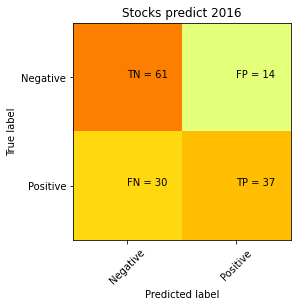

In [39]:
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Stocks predict 2016')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

In [40]:
print(y_pred.sum())
print(len(y_pred) - y_pred.sum())

51
91


In [41]:
y_test.value_counts()

False    75
True     67
Name: target, dtype: int64

In [42]:
all_stocks = X_test.index
print(100*ml.loc[all_stocks]['returns_2016'].mean())
print(100*ml.loc[X_test[y_pred].index]['returns_2016'].mean())
print(100*ml.loc[X_test[~y_pred].index]['returns_2016'].mean())

16.132725591194568
26.015852045178388
10.593830545555278


array(['2014_5', '2015_12', '2014_5', 'mean_month_2015', '2015_4',
       'returns_2015', '2015_7', '2014_3', '2014_11',
       'norm_vol_at_2015_1'], dtype=object)

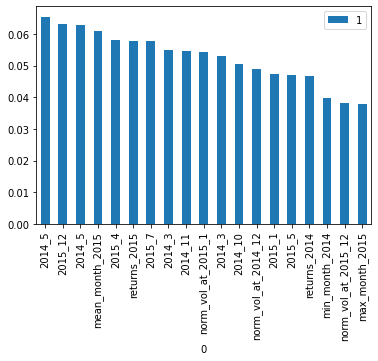

In [43]:
# print(clf.feature_importances_)
# print(X_test.columns)

# X_test.columns
# clf.feature_importances_
ft = pd.DataFrame((zip(X_test.columns,clf.feature_importances_)))
ft.sort_values(1,ascending=False).plot(x=0,y=1,kind='bar')

ft.sort_values(1,ascending=False).head(10)[0].values